In [21]:
import os

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from datetime import datetime

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6

In [16]:
os.path.abspath('')
os.path.join(os.path.abspath(''),'data','AirPassengers.csv')

'C:\\source\\time-series-prediction\\data\\AirPassengers.csv'

In [17]:
ds_loc = os.path.join(os.path.abspath(''),'data','AirPassengers.csv')
ds = pd.read_csv(df_loc)
ds.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [18]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


* Month is string -> change it to datetime format

In [19]:
# Parse string to datetime format
ds['Month'] = pd.to_datetime(ds['Month'], infer_datetime_format=True)
ds_indxd = ds.set_index(['Month'])
ds_indxd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [20]:
ds_indxd.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


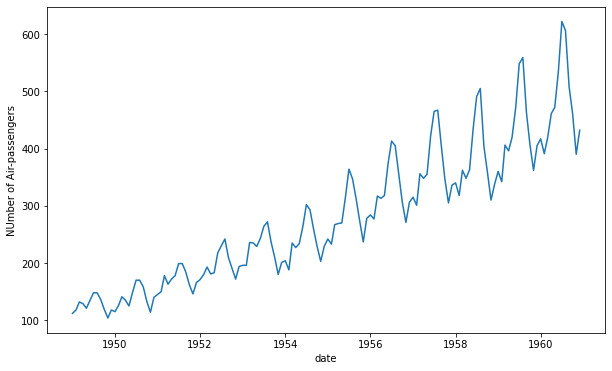

In [23]:
## plot graph

plt.xlabel("date")
plt.ylabel('NUmber of Air-passengers')
plt.plot(ds_indxd)

### From the plot, we can see that the data is not stationary. Now do the test for stationarity

In [46]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    '''
    @Param timeseries: dataset to check stationarity
    @return: '''
    
    # Determine rolling statistics
    moving_avg = timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    # Plot rolling statistics
    orig_data = plt.plot(timeseries, color='black', label='Original Data')
    mean_data = plt.plot(moving_avg, color='blue', label='Rolling Mean')
    std_data = plt.plot(moving_std, color='red', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation Plot')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Dickey-Fuller Test results:')
    df_test = adfuller(timeseries['#Passengers'], autolag="AIC")
    df_stat = pd.Series(df_test[0:4], index=['Test Statistics','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_stat[f'Critical Value {key}',]=value
    print(df_stat)

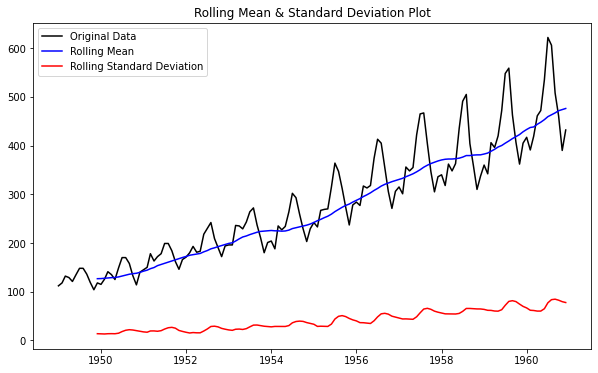

Dickey-Fuller Test results:
Test Statistics                  0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64


In [47]:
test_stationarity(ds_indxd)

### Estimate Trend and make data stationary

### Log-scale

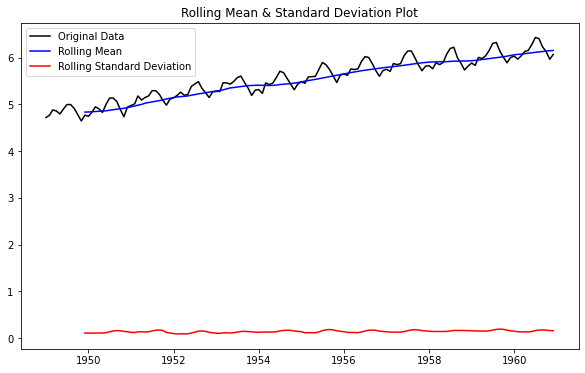

Dickey-Fuller Test results:
Test Statistics                 -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64


In [52]:
# Log-scale
ds_indxd_log = np.log(ds_indxd)
test_stationarity(ds_indxd_log)

#### Up-ward trend is visible

### Subtract Moving-average from Log Scale

In [49]:
moving_avg = ds_indxd_log.rolling(window=12).mean()
#moving_std = ds_indxd_log.rolling(window=12).std()
ds_indxd_log_diff_mov_avg = ds_indxd_log - moving_avg
ds_indxd_log_diff_mov_avg.head()


,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [50]:
# Remove NaN values
ds_indxd_log_diff_mov_avg.dropna(inplace=True)
ds_indxd_log_diff_mov_avg.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


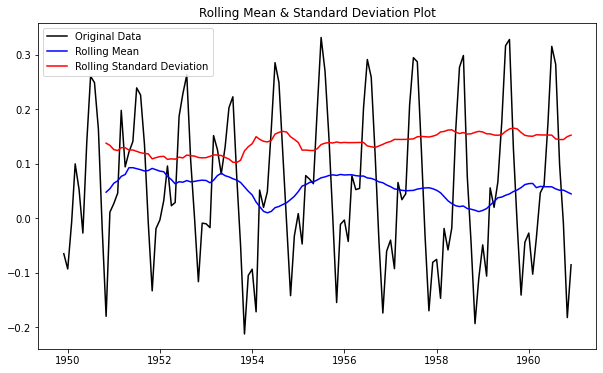

Dickey-Fuller Test results:
Test Statistics                 -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value 1%               -3.486535
Critical Value 5%               -2.886151
Critical Value 10%              -2.579896
dtype: float64


In [51]:
test_stationarity(ds_indxd_log_diff_mov_avg)

#### much better than before - no distinct trend visible

### Exponential Decay Weighted Average on Log Scale

In [55]:
exp_decay_weighted_avg = ds_indxd_log.ewm(halflife=12, min_periods=0, adjust=True).mean() #identify trend
ds_indxd_log_diff_wght_avg = ds_indxd_log - exp_decay_weighted_avg
ds_indxd_log_diff_wght_avg.head()

,#Passengers
Month,
1949-01-01,0.000000
1949-02-01,0.025339
1949-03-01,0.088967
1949-04-01,0.048028
1949-05-01,-0.012415


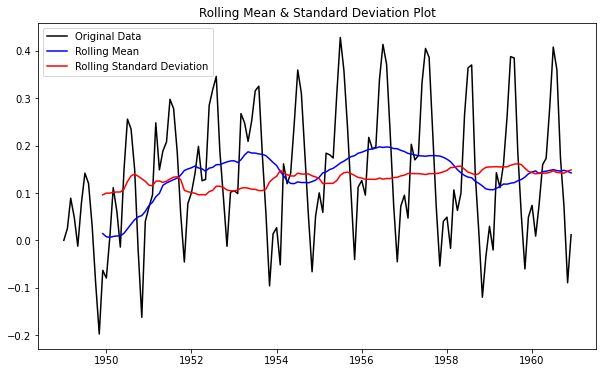

Dickey-Fuller Test results:
Test Statistics                 -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64


In [56]:
test_stationarity(ds_indxd_log_diff_wght_avg)

#### data is stationary

### Shift the value in time-series so that we can use it in forecasting

### Next Step : ARIMA model

### incomplete